# Binomial model: Option pricing

In this notebook, we show how to price European options with the binomial model.

## Delta-hedging

Assume that stock prices only change at discrete time intervals. Further assume that at each time step, the stock price can change to one of two possible outcomes. After a time step $\delta t$, the stock price goes to either $S_u = uS$ or $S_d = dS$ where

\begin{align}
    u &= e^{\sigma \sqrt{\delta t}}, \\
    d &= e^{-\sigma \sqrt{\delta t}}.
\end{align}

Consider a portfolio $\Pi$, long an option ($V$) and short $\Delta$ stocks ($S$). If the price goes to $S_u$, the option price goes to $V_u$ and if the prices goes to $S_d$, the option price goes to $V_d$. At time $T$, there are two possible outcomes:

\begin{align}
    \Pi_u &= V_u - \Delta S_u, \\
    \Pi_d &= V_d - \Delta S_d.
\end{align}

Choosing $\Delta$ so that $\Pi_u = \Pi_d$ gives

\begin{equation}
    \Delta = \frac{V_u - V_d}{S_u - S_d}.
\end{equation}

This choice makes the portfolio risk-free. No arbitrage suggests that the return on the portfolio should equal the risk-free rate. Therefore, assuming the risk-free rate, $r$, is continuous,

\begin{align}
    e^{rT} \Pi &= \Pi_u = \Pi_d = V_d - \Delta S_d = V_d - \left(\frac{V_u - V_d}{S_u - S_d}\right) S_d \notag \\
    &= \frac{V_d(S_u - S_d) - S_d(V_u - V_d)}{S_u - S_d} \notag \\
    &= \frac{V_dS_u - S_dV_u}{S_u - S_d}.
\end{align}

Replacing $\Pi$ by $V - \Delta S$, we obtain

\begin{equation}
    e^{rT}(V - \Delta S) = \frac{V_dS_u - S_dV_u}{S_u - S_d}.
\end{equation}

Therefore,

\begin{align}
    e^{rT}V &= \frac{V_dS_u - S_dV_u}{S_u - S_d} - \left( \frac{V_u - V_d}{S_u - S_d} \right) Se^{rT} \notag \\
    &= \frac{\left( e^{rT}S - S_d \right)}{S_u - S_d} V_u + \frac{\left( S_u - e^{rT}S \right)}{S_u - S_d} V_d
\end{align}

Finally, the option price is given by

\begin{equation}
    V = e^{-rT} (pV_u + (1 - p)V_d)
\end{equation}

where

\begin{equation}
    p = \frac{e^{rT}S - S_d}{S_u - S_d} = \frac{e^{rT} - d}{u - d}
\end{equation}

is the risk-neutral probability.

## Implementation

Consider $N$ time steps where the stock price can either go up are down. The binomial tree, has $N+1$ terminal nodes. The probability of reaching a terminal node (reached with $k$ up moves and $N-k$ down moves) is given by

\begin{equation}
    p_k = \binom{N}{k} p^k (1-p)^{N-k}
\end{equation}

where $k$ denotes the number of up moves to reach the terminal node. The value of the option is the discounted expected value of the payoff at maturity. Therefore, it is given by

\begin{equation}
    V_0 = e^{-rT} \sum_{k = 0}^N \binom{N}{k} p^k (1-p)^{N-k} \max(\theta(S u^k d^{N-k} - K),0) 
\end{equation}

where $K$ is the strike price and $\theta = 1$ for a call and -1 for a put. Expanding $p$ and using the fact that $u = d^{-1}$, we can rewrite the equation as

\begin{equation}
    V_0 = e^{-rT} \sum_{k = 0}^N \frac{N!}{k!(N - k)!} \left( \frac{e^{rT} - d}{u - d} \right)^k \left(\frac{u - e^{rT}}{u - d}\right)^{N-k} \max(\theta(S u^{2k - N} - K),0).
\end{equation}

Let's define some parameters and implement a function to price a call option. Then, we obtain the put price using put-call parity. Put-call parity states that

\begin{equation}
    S + V_p = V_c + Ke^{-rT}
\end{equation}

where $V_p$ is the price of a put and $V_c$ is the price of a call.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def nCk(n, k):
    return np.math.factorial(n) / (np.math.factorial(n-k)*np.math.factorial(k))


def binomial(S0, K , T, r, sigma, N):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r*dt) - d)  /  (u - d)
    Vc = 0 
    for k in range(N+1):
        p_k = nCk(N, k)*p**k * (1-p)**(N-k)
        S_k = S0*(u)**(2*k-N)
        Vc += max(S_k-K,0) * p_k
    
    return Vc*np.exp(-r*T)

# Parameters
S = 100
K = 100
T = 1
sigma = 0.2
r = 0.04
N = 30

# Get option prices
Vc = binomial(S, K, T, r,sigma, N) # call
Vp = K*np.exp(-r*T) + Vc - S # put with put-call parity

print('Call price: ' + str(round(Vc, 5)))
print('Put price:  ' + str(round(Vp, 5)))

Call price: 9.85902
Put price:  5.93797


## Relation to Black-Scholes

In the limit as $N \to \infty$ (i.e., $\delta t \to 0$) the price obtained from the binomial model tends to the one obtained with the Black-Scholes model.

Consider a Taylor series expansion of $u$, $d$ and $e^{r\delta t}$:

\begin{align}
    &u = e^{\sigma \sqrt{\delta t}} = 1 + \sigma \sqrt{\delta t} + \frac{1}{2} \sigma^2 \delta t + \mathcal{O}(\delta t^{\frac{3}{2}}), \\
    &d = e^{-\sigma \sqrt{\delta t}} = 1 - \sigma \sqrt{\delta t} + \frac{1}{2} \sigma^2 \delta t + \mathcal{O}(\delta t^{\frac{3}{2}}), \\
    &e^{r\delta t} = 1 + r \delta t + \mathcal{O}(\delta t^2).
\end{align}

Ignoring the terms of order $\mathcal{O}(\delta t^{\frac{3}{2}})$ and $\mathcal{O}(\delta t^2)$, the risk-neutral probability can be rewritten as

\begin{align}
    p &= \frac{e^{r \delta t} - d}{u - d} = \frac{1 + r \delta t - 1 + \sigma \sqrt{\delta t} - \frac{1}{2} \sigma^2 \delta t}{1 + \sigma \sqrt{\delta t} + \frac{1}{2} \sigma^2 \delta t - 1 + \sigma \sqrt{\delta t} - \frac{1}{2} \sigma^2 \delta t} \notag \\
    & = \frac{\left( r - \frac{1}{2} \sigma^2 \right) \delta t + \sigma \sqrt{\delta t}}{2 \sigma \sqrt{\delta t}} \notag \\
    &= \frac{\left( r - \frac{1}{2} \sigma^2 \right) \sqrt{\delta t}}{2 \sigma} + \frac{1}{2}
\end{align}

We can rewrite the binomial model formula as

\begin{align}
    V(S, t) &= e^{-r \delta t} [pV(uS, t + \delta t) + (1 - p) V(dS, t + \delta t)] \notag \\
    &= e^{-r \delta t} \left[p\big(V(uS, t + \delta t) - V(dS, t + \delta t) \big) + V(dS, t + \delta t)\right].
\end{align}

Let's define $V_u$ and $V_d$ such that 

\begin{align}
    V_u &= V(uS, t + \delta t) = V(S + (uS - S), t + \delta t), \\
    V_d &= V(dS, t + \delta t) = V(S + (dS - S), t + \delta t).
\end{align}

The Taylor series approximations of $V_u$ and $V_d$ are given by

\begin{align}
    V_u &= V(S, t) + (uS - S) \frac{\partial V}{\partial S} + \frac{1}{2} (uS - S)^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \delta t \notag \\
    &= V(S, t) + S(u - 1) \frac{\partial V}{\partial S} + \frac{1}{2} S^2(u - 1)^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \delta t, \\
    V_d &= V(S, t) + S(d - 1) \frac{\partial V}{\partial S} + \frac{1}{2} S^2(d - 1)^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \delta t.
\end{align}

Note that $(u - 1)^2 = (d - 1)^2 = \sigma^2 \delta t$. Therefore, we have 

\begin{equation}
    V_u - V_d = (u - d)S \frac{\partial V}{\partial S} = 2 \sigma \sqrt{\delta t} S \frac{\partial V}{\partial S}.
\end{equation}

It follows that

\begin{align}
    p(V_u - V_d) &= \left[ \frac{\left( r - \frac{1}{2} \sigma^2 \right) \sqrt{\delta t}}{2 \sigma} + \frac{1}{2} \right] 2\sigma \sqrt{\delta t} S \frac{\partial V}{\partial S} \notag \\
    &= \left(\sigma \sqrt{\delta t} + r \delta t - \frac{1}{2}\sigma^2 \delta t \right) S\frac{\partial V}{\partial S}.
\end{align}

Let $V = V(S, t)$. We now insert the everything into the binomial formula. We obtain

\begin{align}
    V(1 + r \delta t) &= \left(\sigma \sqrt{\delta t} + r \delta t - \frac{1}{2}\sigma^2 \delta t \right) S\frac{\partial V}{\partial S} + V + S(d - 1)\frac{\partial V}{\partial S} + \frac{1}{2} S^2(d - 1)^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \delta t \notag \\
    &= \left(\sigma \sqrt{\delta t} + r \delta t - \frac{1}{2}\sigma^2 \delta t \right) S\frac{\partial V}{\partial S} + V + S(-\sigma \sqrt{\delta t} + \frac{1}{2}\sigma^2 \delta t)\frac{\partial V}{\partial S} + \frac{1}{2} S^2\sigma^2 \frac{\partial^2 V}{\partial S^2}\delta t + \frac{\partial V}{\partial t} \delta t.
\end{align}

After canceling terms, we obtain

\begin{equation}
    V + rV\delta t = V + \frac{\partial V}{\partial t}\delta t + \frac{1}{2} S^2\sigma^2 \frac{\partial^2 V}{\partial S^2}\delta t + rS\frac{\partial V}{\partial S} \delta t.
\end{equation}

Finally, subtracting $V$ on both sides and dividing through by $\delta t$, we obtain the Black-Scholes PDE,

\begin{equation}
    \frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0.
\end{equation}

Let's plot the value of the call option from the binomial model using different values for $N$ and compare those prices to the Black-Scholes price.

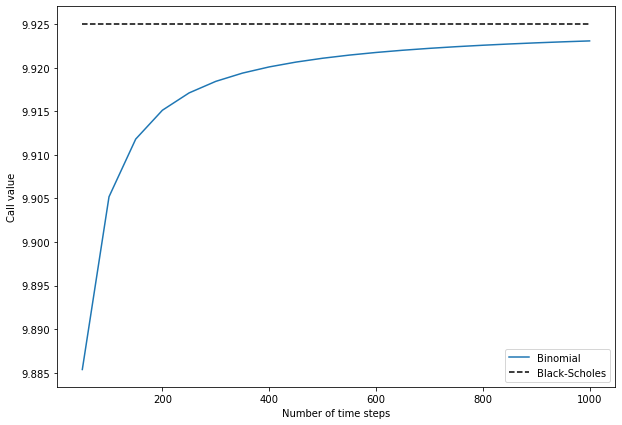

In [2]:
# Function for pricing call with Black-Scholes analytical formula 
def bs_analytical(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    # Calculates call and put values
    Vc = S * norm.cdf(d1) - K * np.exp(-r * (T)) * norm.cdf(d2)
    return Vc    

# BS call price
Vc_bs = bs_analytical(S, K, T, r, sigma)

# Call price from binomial model for different numbers of time steps
Vc_bin = []
for i in range(1, 21):
    Vc_bin.append(binomial(S, K, T, r,sigma, i*50))

# Plot 
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(np.array(range(1, 21))*50, Vc_bin, label='Binomial')
ax.hlines(Vc_bs, 50, 1000, color='k', linestyle='--', label='Black-Scholes')
ax.set_ylabel('Call value')
ax.set_xlabel('Number of time steps')
ax.legend(loc='lower right');

As expected, we see that the call value obtained from the binomial model converges to the price obtained with the Black-Scholes model as $N$ increases.